In [1]:
import numpy as np
import pandas as pd
import torch
from scLENS import scLENS

import cProfile, pstats
import umap
import umap.plot

from sklearn.metrics import rand_score, normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

import matplotlib.pyplot as plt
import seaborn as sns

import re
from scLENS.clustering import scSHC, find_clusters
import anndata
import scanpy as sc

/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sclens/miniconda3/envs/sclens/l

# Params

In [2]:
  # Method-agnostic hyperparameters
params = {'resolutions': np.arange(0.1, 2, 0.1), #np.arange(0.05, 2, 0.05), # [0.3, 0.5, 0.8, 1, 1.2, 1.6, 2, 4, 6, 8],
          'reps': 10,
          'n_jobs': -1}

In [3]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray', 'tab:olive', 'tab:cyan', 'k']

# Display Helper

In [4]:
def display_mappings(X, clusterings, names):
  mapper = umap.UMAP(metric='cosine').fit_transform(X)

  fig, axs = plt.subplots(1, len(clusterings), figsize=(40, 10))
  for ax, cls in enumerate(clusterings):
    labels = np.unique(cls)
    for i, l in enumerate(labels):
      idx = np.where(cls == l)
      axs[ax].scatter(mapper[idx, 0], mapper[idx, 1], s=2, label=l)

    axs[ax].legend()
    axs[ax].set_xlabel('UMAP1')
    axs[ax].set_ylabel('UMAP2')
    axs[ax].tick_params(axis='both',
                  which='both',
                  bottom=False,
                  top=False,
                  labelbottom=False,
                  labelleft=False)
    axs[ax].set_title(names[ax])
  plt.show()

# Evaluate Func

In [5]:
def evaluate(filepaths, save_scl, save_noscl, overwrite=False, **params):
  scl_pool, noscl_pool = [], []

  for file in filepaths:
    if overwrite or save.loc[file].isnull().all():
      print(file)
      df = pd.read_csv(file)
      y_true_full = df['cell']
      df = df.drop('cell', axis=1)

      sclens = scLENS(device=torch.device('cuda:0'))
      sclens.preprocess(df)
      X_transform = sclens.fit_transform()

      adata = anndata.AnnData(X=df, obs=pd.DataFrame(y_true_full))

      sc.pp.filter_cells(adata, min_genes=200)
      sc.pp.filter_genes(adata, min_cells=3)

      sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

      kept_cells = adata.obs.n_genes_by_counts.values < 2500
      adata = adata[adata.obs.n_genes_by_counts < 2500, :]

      sc.pp.normalize_total(adata, target_sum=1e4)
      sc.pp.log1p(adata)
      sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
      adata = adata[:, adata.var.highly_variable]
      sc.pp.scale(adata, max_value=10)

      sc.tl.pca(adata, svd_solver='arpack')

      X = df.values[kept_cells]
      X_transform = adata.obsm['X_pca']
      y_true = adata.obs['cell']

      sch_scl = sclens.cluster(df, method='scSHC', n_jobs=-1)
      sch_noscl = scSHC(X, X_transform, n_jobs=-1)

      sch_full = np.zeros_like(y_true_full) - 1
      sch_full[kept_cells] = sch_noscl

      sch_cls_noscl = Clustering().from_membership_list(sch_full)
      sch_cls_scl = Clustering().from_membership_list(sch_scl)
      true_cls = Clustering().from_membership_list(y_true_full)

      # display_mappings(X_transform, [y_true, sch_noscl, sch_scl], ['True', 'scSHC', 'scLENS + scSHC'])

      noscl_score = sim.element_sim(true_cls, sch_cls_noscl)
      scl_score = sim.element_sim(true_cls, sch_cls_scl)

      scl_pool.append(scl_score)
      noscl_pool.append(noscl_score)

      scores = {'scSHC': noscl_score, 'scLENS + scSHC': scl_score}
      schemes = ['Element-Centric Clustering']

      x = np.arange(len(schemes))
      width = 0.25
      multiplier = 0

      fig, ax = plt.subplots(layout='constrained')

      for name, val in scores.items():
          offset = width * multiplier
          rects = ax.bar(x + offset, val, width, label=name)
          ax.bar_label(rects, padding=2)
          multiplier += 1

      ax.set_ylabel('Score')
      ax.set_title(' '.join(file.split('/')[2:]))
      ax.set_xticks(x + width/2, schemes)
      ax.legend(loc='upper right', ncols=2)

      plt.show()
      del sclens
      torch.cuda.empty_cache()

      save_scl.loc[file, 'ECC'] = scl_score
      save_noscl.loc[file, 'ECC'] = noscl_score
      save_scl.to_csv('scSHC_scores.csv')
      save_noscl.to_csv('scSHC_nosclens_scores.csv')

  return scl_pool, noscl_pool

# Run Dataset Evaluation

In [6]:
import os

filepaths = []

for dir in os.listdir('data'):
  if dir.endswith('.csv.gz'):
    filepaths.append(os.path.join('data', dir))
  else:
    for dir2 in os.listdir(os.path.join('data', dir)):
      if dir2.endswith('.csv.gz'):
        filepaths.append(os.path.join('data', dir, dir2))
      else:
        for f in os.listdir(os.path.join('data', dir, dir2)):
          if f.endswith('.csv.gz'):
            filepaths.append(os.path.join('data', dir, dir2, f))

filepaths

['data/Zheng_real_data/Imbalanced/z_data_3706.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_4757.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_4292.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_5730.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_4952.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_12073.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_3869.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_7993.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_2410.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_785.csv.gz',
 'data/sim_Tcell/2250-1220.csv.gz',
 'data/sim_Tcell/5930-3210.csv.gz',
 'data/sim_Tcell/2251-1179.csv.gz',
 'data/sim_Tcell/3276-1042.csv.gz',
 'data/sim_Tcell/2972-1523.csv.gz',
 'data/sim_Tcell/4249-2916.csv.gz',
 'data/sim_Tcell/4320-2134.csv.gz',
 'data/sim_Tcell/3689-1878.csv.gz',
 'data/sim_Tcell/5974-3858.csv.gz',
 'data/sim_Tcell/6006-2261.csv.gz',
 'data/sim_Tcell/6083-4496.csv.gz',
 'data/sim_Tcell/4797-2332.csv.gz',
 'data/sim_Tcell/5960-1400.c

In [7]:
if not os.path.exists('scSHC_scores.csv'):
  save = pd.DataFrame(index=filepaths, columns=['ECC'])
  save.to_csv('scSHC_scores.csv')
else:
  save = pd.read_csv('scSHC_scores.csv', index_col=0)

if not os.path.exists('scSHC_nosclens_scores.csv'):
  save_noscl = pd.DataFrame(index=filepaths, columns=['ECC'])
  save_noscl.to_csv('scSHC_nosclens_scores.csv')
else:
  save_noscl = pd.read_csv('scSHC_nosclens_scores.csv', index_col=0)

In [8]:
save

,ECC
data/Zheng_real_data/Imbalanced/z_data_3706.csv.gz,NaN
data/Zheng_real_data/Imbalanced/z_data_4757.csv.gz,NaN
data/Zheng_real_data/Imbalanced/z_data_4292.csv.gz,NaN
data/Zheng_real_data/Imbalanced/z_data_5730.csv.gz,NaN
data/Zheng_real_data/Imbalanced/z_data_4952.csv.gz,NaN
data/Zheng_real_data/Balanced/z_data_12073.csv.gz,NaN
data/Zheng_real_data/Balanced/z_data_3869.csv.gz,NaN
data/Zheng_real_data/Balanced/z_data_7993.csv.gz,NaN
data/Zheng_real_data/Balanced/z_data_2410.csv.gz,NaN
data/Zheng_real_data/Balanced/z_data_785.csv.gz,NaN


data/Zheng_real_data/Imbalanced/z_data_3706.csv.gz


100%|██████████| 10/10 [00:55<00:00,  5.60s/it]
/home/sclens/Documents/scLENS-py/scLENS/scLENS.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_clean = torch.tensor(X).to(self.device, dtype=torch.double)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


ClusterID: 7334, Num tests: 3668, Significance: 0.0, Total clusters: 0


/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:338: RuntimeWarning: invalid value encountered in divide
  y2 = (X - mu) ** 2 / mu


ClusterID: 7333, Num tests: 2483, Significance: 0.0, Total clusters: 0
ClusterID: 7331, Num tests: 1615, Significance: 0.0, Total clusters: 0
ClusterID: 7330, Num tests: 1358, Significance: 0.0, Total clusters: 0
ClusterID: 7328, Num tests: 798, Significance: 5.275125442444782e-81, Total clusters: 0
ClusterID: 7323, Num tests: 645, Significance: 0.0, Total clusters: 0
ClusterID: 7322, Num tests: 642, Significance: 2.8823651817638194e-09, Total clusters: 0
ClusterID: 7318, Num tests: 638, Significance: 0.6594670905729391, Total clusters: 1
ClusterID: 7245, Num tests: 4, Significance: 1.1744261708233309e-63, Total clusters: 1
ClusterID: 3785, Num tests: 2, Significance: nan, Total clusters: 2


/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:452: RuntimeWarning: divide by zero encountered in divide
  X = np.transpose(X.T / l2_norm) * np.mean(l2_norm)
/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:452: RuntimeWarning: invalid value encountered in divide
  X = np.transpose(X.T / l2_norm) * np.mean(l2_norm)
/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:342: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(y2.shape[0]) * (disp - 1) / np.sqrt(np.var(y2, 0))


ClusterID: 3719, Num tests: 2, Significance: nan, Total clusters: 3
ClusterID: 3724, Num tests: 3, Significance: 0.8994693342732121, Total clusters: 4
ClusterID: 7300, Num tests: 153, Significance: 4.2931576574270293e-33, Total clusters: 4
ClusterID: 7252, Num tests: 151, Significance: 0.8587361985694264, Total clusters: 5
ClusterID: 3726, Num tests: 2, Significance: nan, Total clusters: 6
ClusterID: 7325, Num tests: 560, Significance: 1.9549889206608425e-53, Total clusters: 6
ClusterID: 7317, Num tests: 210, Significance: 7.794129231141713e-14, Total clusters: 6
ClusterID: 7292, Num tests: 206, Significance: 0.6863394979210519, Total clusters: 7
ClusterID: 7227, Num tests: 4, Significance: 1.7372346354893933e-40, Total clusters: 7
ClusterID: 7001, Num tests: 2, Significance: 2.376685419987664e-177, Total clusters: 7
ClusterID: 2658, Num tests: 1, Significance: 1, Total clusters: 8
ClusterID: 2429, Num tests: 1, Significance: 1, Total clusters: 9
ClusterID: 3711, Num tests: 2, Signific

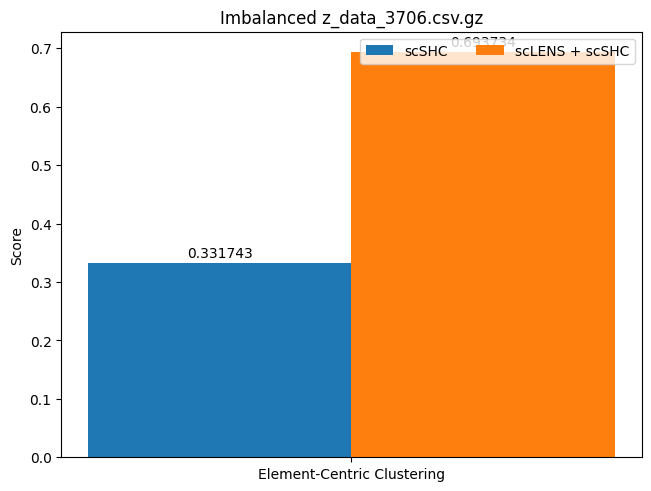

data/Zheng_real_data/Imbalanced/z_data_4757.csv.gz


100%|██████████| 10/10 [01:36<00:00,  9.66s/it]
/home/sclens/Documents/scLENS-py/scLENS/scLENS.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_clean = torch.tensor(X).to(self.device, dtype=torch.double)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/sclens/miniconda3/envs/sclens/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


ClusterID: 9440, Num tests: 4721, Significance: 0.0, Total clusters: 0


/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:338: RuntimeWarning: invalid value encountered in divide
  y2 = (X - mu) ** 2 / mu


ClusterID: 9439, Num tests: 1763, Significance: 0.00029238701295921353, Total clusters: 0
ClusterID: 9437, Num tests: 1102, Significance: 0.0, Total clusters: 0
ClusterID: 9427, Num tests: 491, Significance: 0.0, Total clusters: 0
ClusterID: 9403, Num tests: 458, Significance: 1.6131537754159211e-74, Total clusters: 0
ClusterID: 9393, Num tests: 455, Significance: 0.0, Total clusters: 0
ClusterID: 8963, Num tests: 452, Significance: 0.0, Total clusters: 0
ClusterID: 8665, Num tests: 365, Significance: 0.0, Total clusters: 0
ClusterID: 8587, Num tests: 359, Significance: 1.7258601253566335e-13, Total clusters: 0
ClusterID: 8437, Num tests: 351, Significance: 0.0, Total clusters: 0
ClusterID: 8406, Num tests: 349, Significance: 5.0010143808492106e-18, Total clusters: 0
ClusterID: 8380, Num tests: 343, Significance: 0.004362750956378987, Total clusters: 1
ClusterID: 7972, Num tests: 6, Significance: 0.7978208297478009, Total clusters: 2
ClusterID: 4846, Num tests: 2, Significance: nan, To

/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:452: RuntimeWarning: invalid value encountered in divide
  X = np.transpose(X.T / l2_norm) * np.mean(l2_norm)
/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:342: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(y2.shape[0]) * (disp - 1) / np.sqrt(np.var(y2, 0))


ClusterID: 7975, Num tests: 8, Significance: 3.0348869381759017e-22, Total clusters: 3
ClusterID: 7171, Num tests: 4, Significance: 2.4075135656585422e-32, Total clusters: 3
ClusterID: 4856, Num tests: 2, Significance: nan, Total clusters: 4
ClusterID: 4848, Num tests: 2, Significance: nan, Total clusters: 5
ClusterID: 6606, Num tests: 4, Significance: 5.48063838812534e-30, Total clusters: 5
ClusterID: 4908, Num tests: 2, Significance: nan, Total clusters: 6
ClusterID: 4857, Num tests: 2, Significance: nan, Total clusters: 7
ClusterID: 8026, Num tests: 6, Significance: 1.9232818489496218e-62, Total clusters: 7
ClusterID: 7793, Num tests: 4, Significance: 1.058136552890572e-36, Total clusters: 7
ClusterID: 4855, Num tests: 2, Significance: nan, Total clusters: 8
ClusterID: 4850, Num tests: 2, Significance: nan, Total clusters: 9
ClusterID: 4851, Num tests: 2, Significance: nan, Total clusters: 10
ClusterID: 8488, Num tests: 87, Significance: 0.12505893429913723, Total clusters: 11
Clust

/home/sclens/Documents/scLENS-py/scLENS/cluster_utils.py:452: RuntimeWarning: divide by zero encountered in divide
  X = np.transpose(X.T / l2_norm) * np.mean(l2_norm)


ClusterID: 4838, Num tests: 3, Significance: 0.8569446223765369, Total clusters: 4
ClusterID: 8842, Num tests: 4, Significance: 1.819503681118284e-46, Total clusters: 4
ClusterID: 4846, Num tests: 2, Significance: nan, Total clusters: 5
ClusterID: 4784, Num tests: 2, Significance: nan, Total clusters: 6
ClusterID: 9327, Num tests: 12, Significance: 0.0013982137261259893, Total clusters: 7
ClusterID: 9420, Num tests: 468, Significance: 0.73835669438306, Total clusters: 8
ClusterID: 9424, Num tests: 661, Significance: 9.488671636898221e-28, Total clusters: 8
ClusterID: 9399, Num tests: 362, Significance: 5.729327085232333e-78, Total clusters: 8
ClusterID: 9337, Num tests: 301, Significance: 0.007963107033377288, Total clusters: 9
ClusterID: 9011, Num tests: 61, Significance: 0.006915062955269381, Total clusters: 10
ClusterID: 9254, Num tests: 299, Significance: 0.7922604981929253, Total clusters: 11
ClusterID: 9375, Num tests: 611, Significance: 1.699591713989803e-84, Total clusters: 11


KeyboardInterrupt: 

In [9]:
chsr_score, mltk_score = evaluate(filepaths, save, save_noscl, overwrite=True, **params)

In [ ]:
save.mean()

# Load Scores, Compare

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BIMAG

In [ ]:
save_ecc = pd.read_csv('save.csv', index_col=0)
save_ecc

In [ ]:
save_rand_nmi = pd.read_csv('RandIndex_NMI.csv', index_col=0)
save_rand_nmi

In [ ]:
scl_scores = pd.concat([save_ecc, save_rand_nmi], axis=1)
scl_scores = scl_scores.drop(['ChooseR_ECC', 'ChooseR_RandIndex', 'ChooseR_NormMI'], axis=1)
scl_scores

In [ ]:
scl_scores.mean()

In [ ]:
noscl_scores = pd.read_csv('save_no_sclens.csv', index_col=0)
noscl_scores

In [ ]:
scl_means = scl_scores.mean()
noscl_means = noscl_scores.mean()

scores = {'scLENS + MultiK': [scl_means['MultiK_RandIndex'], scl_means['MultiK_NormMI'], scl_means['MultiK_ECC']],
          'MultiK': [noscl_means['MultiK_RandIndex'], noscl_means['MultiK_NormMI'], noscl_means['MultiK_ECC']]}
schemes = ['Rand Index', 'Norm Mutual Information', 'Element-Centric']

x = np.arange(len(schemes))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, val in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, val, width, label=name)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('Mean Scores')
ax.set_xticks(x + width/2, schemes)
ax.legend(loc='upper right', ncols=2)

plt.show()

# Per Dataset

In [ ]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)

for dataset in scl_scores.index:
  scl = scl_scores.loc[dataset, 'MultiK_ECC']
  noscl = noscl_scores.loc[dataset, 'MultiK_ECC']

  ax.plot([0, 1], [noscl, scl], 'k--', linewidth=1)
  ax.scatter(0, noscl, color='k')
  ax.scatter(1, scl, color='k')

ax.set_title('Per-Dataset ECC')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No scLENS', 'scLENS'])
ax.set_ylabel('ECC Score')

plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)

for dataset in scl_scores.index:
  scl = scl_scores.loc[dataset, 'MultiK_RandIndex']
  noscl = noscl_scores.loc[dataset, 'MultiK_RandIndex']

  ax.plot([0, 1], [noscl, scl], 'k--', linewidth=1)
  ax.scatter(0, noscl, color='k')
  ax.scatter(1, scl, color='k')

ax.set_title('Per-Dataset Rand Index')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No scLENS', 'scLENS'])
ax.set_ylabel('Rand Index Score')

plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)

for dataset in scl_scores.index:
  scl = scl_scores.loc[dataset, 'MultiK_NormMI']
  noscl = noscl_scores.loc[dataset, 'MultiK_NormMI']

  ax.plot([0, 1], [noscl, scl], 'k--', linewidth=1)
  ax.scatter(0, noscl, color='k')
  ax.scatter(1, scl, color='k')

ax.set_title('Per-Dataset NMI')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No scLENS', 'scLENS'])
ax.set_ylabel('Norm Mutual Information Score')

plt.show()

# Investigate

In [ ]:
from scLENS.clustering import multiK

In [ ]:
scl_check = scl_scores.drop(['MultiK_RandIndex', 'MultiK_NormMI'], axis=1)[scl_scores['MultiK_ECC'] < noscl_scores['MultiK_ECC']]
noscl_check = noscl_scores.drop(['MultiK_RandIndex', 'MultiK_NormMI'], axis=1)[scl_scores['MultiK_ECC'] < noscl_scores['MultiK_ECC']]
scl_check

In [ ]:
noscl_check

In [ ]:
for dataset in scl_check.index:
  df = pd.read_csv(dataset)
  y_true = df['cell']
  df = df.drop(['cell'], axis=1)

  scl = scLENS(device=torch.device('cuda:0'))
  scl.preprocess(df)
  X_transform_scl = scl.fit_transform()
  mltk_scl = scl.cluster(df, method='multiK', **params)

  adata = anndata.AnnData(X=df, obs=pd.DataFrame(y_true))

  sc.pp.filter_cells(adata, min_genes=200)
  sc.pp.filter_genes(adata, min_cells=3)

  sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

  adata = adata[adata.obs.n_genes_by_counts < 2500, :]

  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
  adata = adata[:, adata.var.highly_variable]
  sc.pp.scale(adata, max_value=10)

  sc.tl.pca(adata, svd_solver='arpack')

  X_transform_noscl = adata.obsm['X_pca']
  y_true_noscl = adata.obs['cell']

  res = multiK(X_transform_noscl, **params)

  mltk_noscl = find_clusters(X_transform_noscl,
                             n_neighbors=20,
                             min_weight=1/15,
                             res=res,
                             n_iterations=-1)

  display_mappings(X_transform_scl, [y_true, mltk_scl], ['True', 'scLENS MultiK'])
  display_mappings(X_transform_noscl, [y_true_noscl, mltk_noscl], ['True', 'No scLENS MultiK'])